## This script is used to plot the tune shift with amplitude for two different time periods of the same study
- For the tune calculation the NAFF algorithm is used.
- Be careful each time to introduce the configuration file you need along with the file that contains the turn by turn data (from /afs)

In [1]:
import os
import sys
import numpy as np
from math import *
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import NAFFlib as pnf
import json

### Test that you have acces to the /afs directory where your data are stored
If permision denied
- $USERNAME@CERN.CH 
- aklog

In [2]:
ls /afs/cern.ch/work/n/natriant/private

my_tracking_model_htcondor/  simulation_data_2018/  sixdesk/  workspaces/


### Plotting parameters

In [3]:
params = {'legend.fontsize': 12,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 20,
          'axes.titlesize': 18,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

### Import the parameters of the study

In [4]:
data = {}
with open('./configuration_files/config_10000turns.json', "r") as read_file:
        data = json.load(read_file)
my_afs_path = '/afs/cern.ch/work/n/natriant/private/my_tracking_model_htcondor/tracking_data/'

### Define the set of parameters of the study

In [5]:
study_name = 'Qx62.78_ksi0.010_g0.200_delta0.050_betax115.75_particles15000_turns10000'
df = pd.read_pickle(my_afs_path+study_name+'.pkl') 

### Create two new data frames for each one of the time frame you want to stuy

In [6]:
lim_1_min = 0
lim_1_max = 1000
lim_2_min = 1001 # this value correpsonds to the index, not the number of turns
lim_2_max = 2000

df_1 = df[lim_1_min:lim_1_max]
df_2 = df[lim_2_min:lim_2_max]

### Tune shift with amplitude
- We need to store the data in groups of particles. 
- In our data frames are in groups of turns

In [7]:
# each of the dictionaries below correpspond to one of the above data frames which is indicated by the index
x1_data = {}
px1_data = {}
x2_data = {}
px2_data = {}
for particle in range(data['study_parameters']['particles']):
    x1_data[particle] = []
    px1_data[particle] = []
    x2_data[particle] = []
    px2_data[particle] = []

In [8]:
# loop for the first time frame
for particle in range(data['study_parameters']['particles']):
    for turn in range(lim_1_min, lim_1_max):
        x1_data[particle].append(df_1.at[turn,'x'][particle])
        px1_data[particle].append(df_1.at[turn,'px'][particle])
# loop for the second time frame
for particle in range(data['study_parameters']['particles']):
    for turn in range(lim_2_min, lim_2_max):
        x2_data[particle].append(df_2.at[turn,'x'][particle])
        px2_data[particle].append(df_2.at[turn,'px'][particle])

### Exclude the particles that are lost, otherwise NAFF crashes.

In [9]:
lost_particles_1 = []
lost_particles_2 = []
Qx_list_1 = []
Qx_list_2 = []

for particle in range(data['study_parameters']['particles']):
    if np.isnan(x1_data[particle]).any() or np.isnan(px1_data[particle]).any():
        lost_particles_1.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x1 = x1_data[particle] # normalise by derivation with beta function
        Qx_list_1.append(pnf.get_tune(np.array(signal_x1)))
 
    if np.isnan(x2_data[particle]).any() or np.isnan(px2_data[particle]).any():
        lost_particles_2.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x2 = x2_data[particle] # normalise by derivation with beta function
        Qx_list_2.append(pnf.get_tune(np.array(signal_x2)))
 


### Use normalised coordiantes
\begin{equation}
x_{N} = \frac{x}{\sqrt{\beta(s)}} \\
px_{N} = px \cdot \sqrt{\beta(s)}
\end{equation}

### Calculate the actions Jx for the two diffrent time integrals - Jx_initial and Jx_last
\begin{equation}
J_x = \frac{x_{N}^2 + px_{N}^2}{2} 
\end{equation}

In [34]:
flag_init_and_last = False # if you want to calculate the actions of all the particles at the first and last turn
if flag_init_and_last:
    x_norm_init = df.at[0,'x']/sqrt(data['machine_parameters']['beta_x']) # the index 0 corresponds to turn
    px_norm_init = df.at[0,'px']*sqrt(data['machine_parameters']['beta_x'])
    Jx_initial = (x_norm_init**2 + px_norm_init**2)
    x_norm_last = df.at[2000,'x']/sqrt(data['machine_parameters']['beta_x']) # the index 0 corresponds to turn
    px_norm_last = df.at[2000,'px']*sqrt(data['machine_parameters']['beta_x'])
    Jx_last = (x_norm_last**2 + px_norm_last**2)

### Calculate the average of the actions for the two interals
- This is more correct: See 15oct2019

In [17]:
# the indeces 1, 2 corrsepond to the first and second time integral respectively
flag_average_actions = True
if flag_average_actions:
    Jx1_mean = [] #Here you will save the average actions for each particle over the first and last 1000 turns
    Jx2_mean = []
    # each of the dictionaries below correpspond to one of the above data frames which is indicated by the index
    Jx1_data = {}
    Jx2_data = {}
    for particle in range(data['study_parameters']['particles']):
        Jx1_data[particle] = []
        Jx2_data[particle] = []
    
    for particle in range(data['study_parameters']['particles']):
        Jx1_data[particle] = (np.array(x1_data[particle])/sqrt(data['machine_parameters']['beta_x']))**2 + (np.array(px1_data[particle])*sqrt(data['machine_parameters']['beta_x']))**2
        Jx2_data[particle] = (np.array(x2_data[particle])/sqrt(data['machine_parameters']['beta_x']))**2 + (np.array(px2_data[particle])*sqrt(data['machine_parameters']['beta_x']))**2
        Jx1_mean.append(np.mean(Jx1_data[particle]))
        Jx2_mean.append(np.mean(Jx2_data[particle]))   

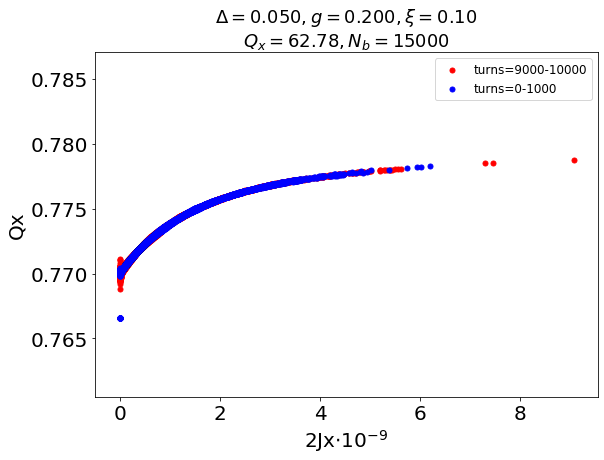

In [27]:
Qx_list_plot_1 = [1-i for i in Qx_list_1]
Qx_list_plot_2 = [1-i for i in Qx_list_2]

plt.scatter(np.array(Jx2_mean)*1e9, Qx_list_plot_2, c = 'r', label='turns={}-{}'.format(int(df.at[lim_2_min,'turn']), int(df.at[lim_2_max,'turn'])+1))
plt.scatter(np.array(Jx1_mean)*1e9, Qx_list_plot_1, c = 'b', label='turns={}-{}'.format(int(df.at[lim_1_min,'turn']), int(df.at[lim_1_max,'turn'])))

plt.xlabel('2Jx'+r'$\cdot 10^{-9}$')
plt.ylabel('Qx')
plt.title(r'$\Delta={:.3f}, g={:.3f}, \xi=0.10$'.format(data['Noise']['values_limits']['max'], data['Feedback']['values_limits']['max'],data['BB']['values_limits']['max'])+'\n'+'$Q_x={}, N_b={}$'.format(data['machine_parameters']['Qx_init'], data['study_parameters']['particles'] ))
plt.tight_layout()
plt.legend()
savefig = False
if savefig:
    plt.savefig('./figures/tune_shift_Qx62.78_ksi0.010_g0.200_delta0.050_betax115.75_particles15000_turns10000.png')#.format(Delta, version))

### Plot phase space

In [19]:
n_turns = 1000 # number of turns saved in the data frame
n_particles = 15000
my_x = np.zeros((n_turns, n_particles))
my_px = np.zeros((n_turns, n_particles))
for i in range(n_turns):
    my_x[i]=df_1['x'][i]
    my_px[i]=df_1['px'][i]

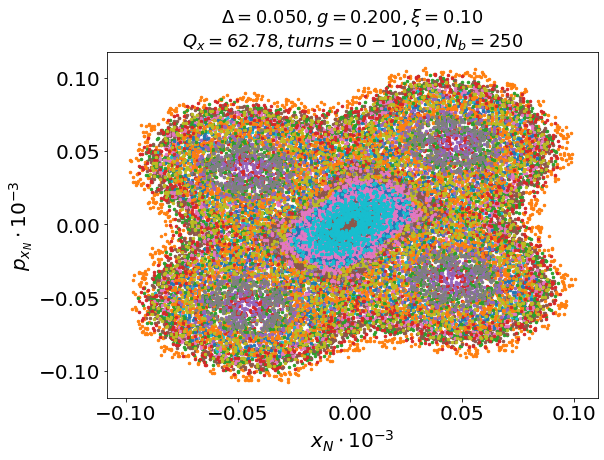

In [23]:
N_observation = 250 # number of particles that you will plot
plt.plot(my_x[:n_turns, ::N_observation]/sqrt(data['machine_parameters']['beta_x'])*1e3, my_px[:n_turns, ::N_observation]*sqrt(data['machine_parameters']['beta_x'])*1e3, '.')
plt.xlabel(r'$x_N \cdot 10^{-3}$')
plt.ylabel(r'$p_{x_N} \cdot 10^{-3}$')
plt.title(r'$\Delta={:.3f}, g={:.3f}, \xi=0.10$'.format(data['Noise']['values_limits']['max'], data['Feedback']['values_limits']['max'],data['BB']['values_limits']['max'])+'\n'+'$Q_x={}, turns={}-{}, N_b={}$'.format(data['machine_parameters']['Qx_init'], 0, 1000, N_observation ))
plt.tight_layout()
savefig = False
if savefig:
     plt.savefig('./figures/phase_space_Qx62.78_ksi0.010_g0.200_delta0.050_betax115.75_particles15000_turns10000.png')#.format(Delta, version))